In [124]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [125]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [126]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Death rate']:  
    dta_cnt.append(-(1.+acc.count(k*1000)))
    acc.append(k*1000)
dta_cnt=np.array(dta_cnt)

## generation of vector for plotting samples under histograms
accDeath=[]
dta_cntDeath=[]
for k in Airline_data['Passenger deaths']:  
    dta_cntDeath.append(-(1.+accDeath.count(k)))
    accDeath.append(k)
dta_cntDeath=np.array(dta_cntDeath)



Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


## Lab 4.1. The rate is constant for all years and not depending on anything.


In [128]:
# So I calculate median value to get constant death rate value for all years

median_pd=np.median(Airline_data["Passenger deaths"])
mean_pd=np.mean(Airline_data["Passenger deaths"])
print("Passengers deaths median: "+str(median_pd))
print("Passengers deaths mean: "+str(mean_pd))


Passengers deaths median: 759.0
Passengers deaths mean: 691.9


In [129]:
mean_pd=np.mean(Airline_data["Passenger deaths"])
cinf_lam = az.hpd(Airline_data["Passenger deaths"],0.95)
print('Mean lambda : {:4.2f}'.format(mean_pd))
#print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')
#hpd_width=cinf_lam[1]-cinf_lam[0]
#sd=hpd_width/2;
#print('Standard deviation: {:4.2f}'.format(sd))

Mean lambda : 691.90


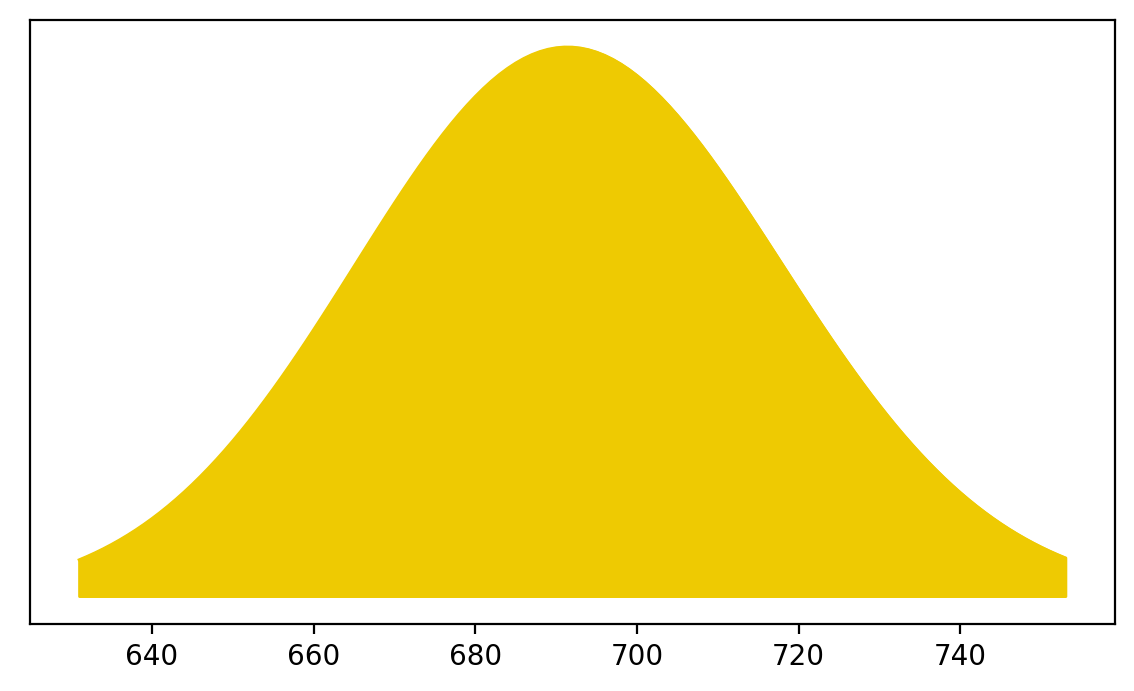

In [130]:
mu=mean_pd;
loc=sd
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x = np.arange(stats.poisson.ppf(0.01, mu),stats.poisson.ppf(0.99, mu))

#a- alpha

ax2.plot(x,stats.poisson.pmf(x,mu),color=dark,linewidth=1)
ax2.fill_between(x,stats.poisson.pmf(x,mu),color=dark)
#ax2.fill_between(x4,stats.invgamma.pdf(x4,a=alpha,scale=sigma,loc=5),0,color=dark)
ax2.set_yticks([])
#ax2.set_xticks([0,qua[0]])
plt.show()

In [132]:
with open('poisson_prior.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  real lam;
}


generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lam);
  }
}



In [133]:
model_prior=pystan.StanModel('poisson_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_941ddc41fd8ed061ff465f3ef8b367ff NOW.


In [134]:
R=1000
data = dict(M = 1,
            lam = mean_pd)
sim_uf=model_prior.sampling(data=data,
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

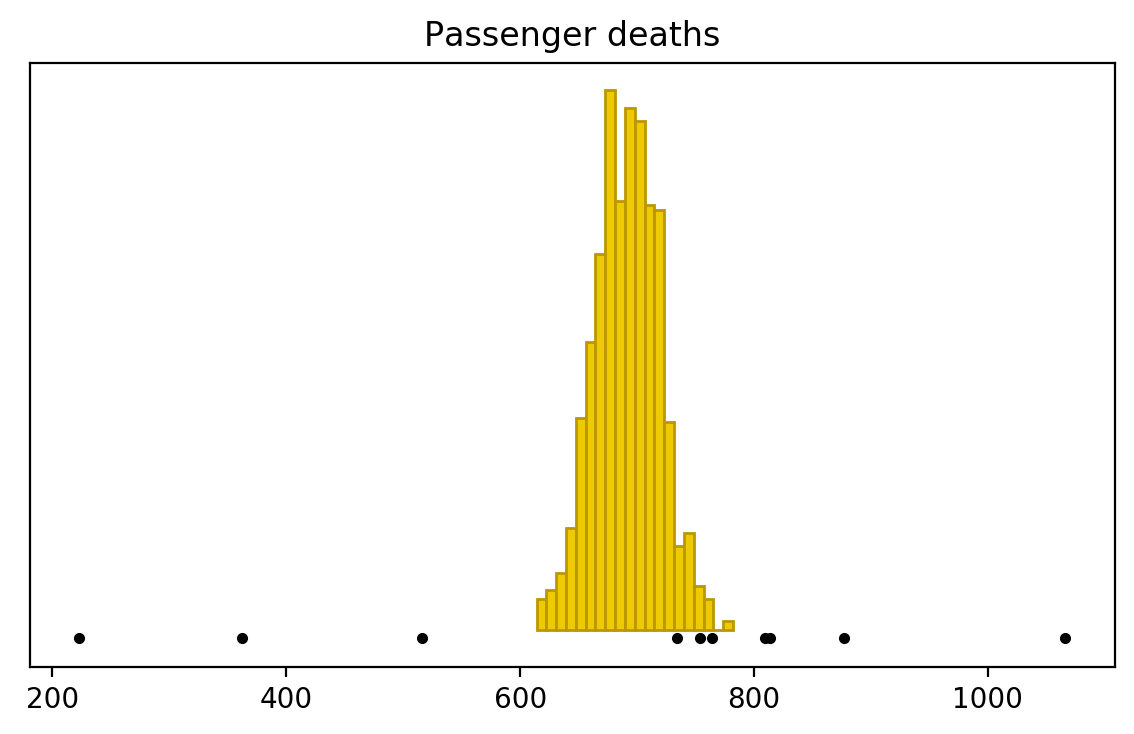

In [136]:
sigma=sd
params=sim_uf.extract()
y_sim=params['y_sim']

fig, ax = plt.subplots(1, 1,figsize=(7, 4))
ax.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax.scatter(accDeath,0.0002*dta_cntDeath,color='black',marker='.',zorder=2)
ax.set_yticks([])

ax.set_title('Passenger deaths')
plt.show()

## Posterior inference and posterior predictive checks

In [137]:
with open('poisson_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  int y[M];//number of deaths
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(691,421);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [138]:
model=pystan.StanModel('poisson_fit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85c7a81d87a72f84b9208b7c6f98c845 NOW.


In [139]:
data = dict(M = len(Airline_data),
            y = Airline_data['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [140]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [141]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 692.09
89% confidence interval: [ 678.25 704.72 ]


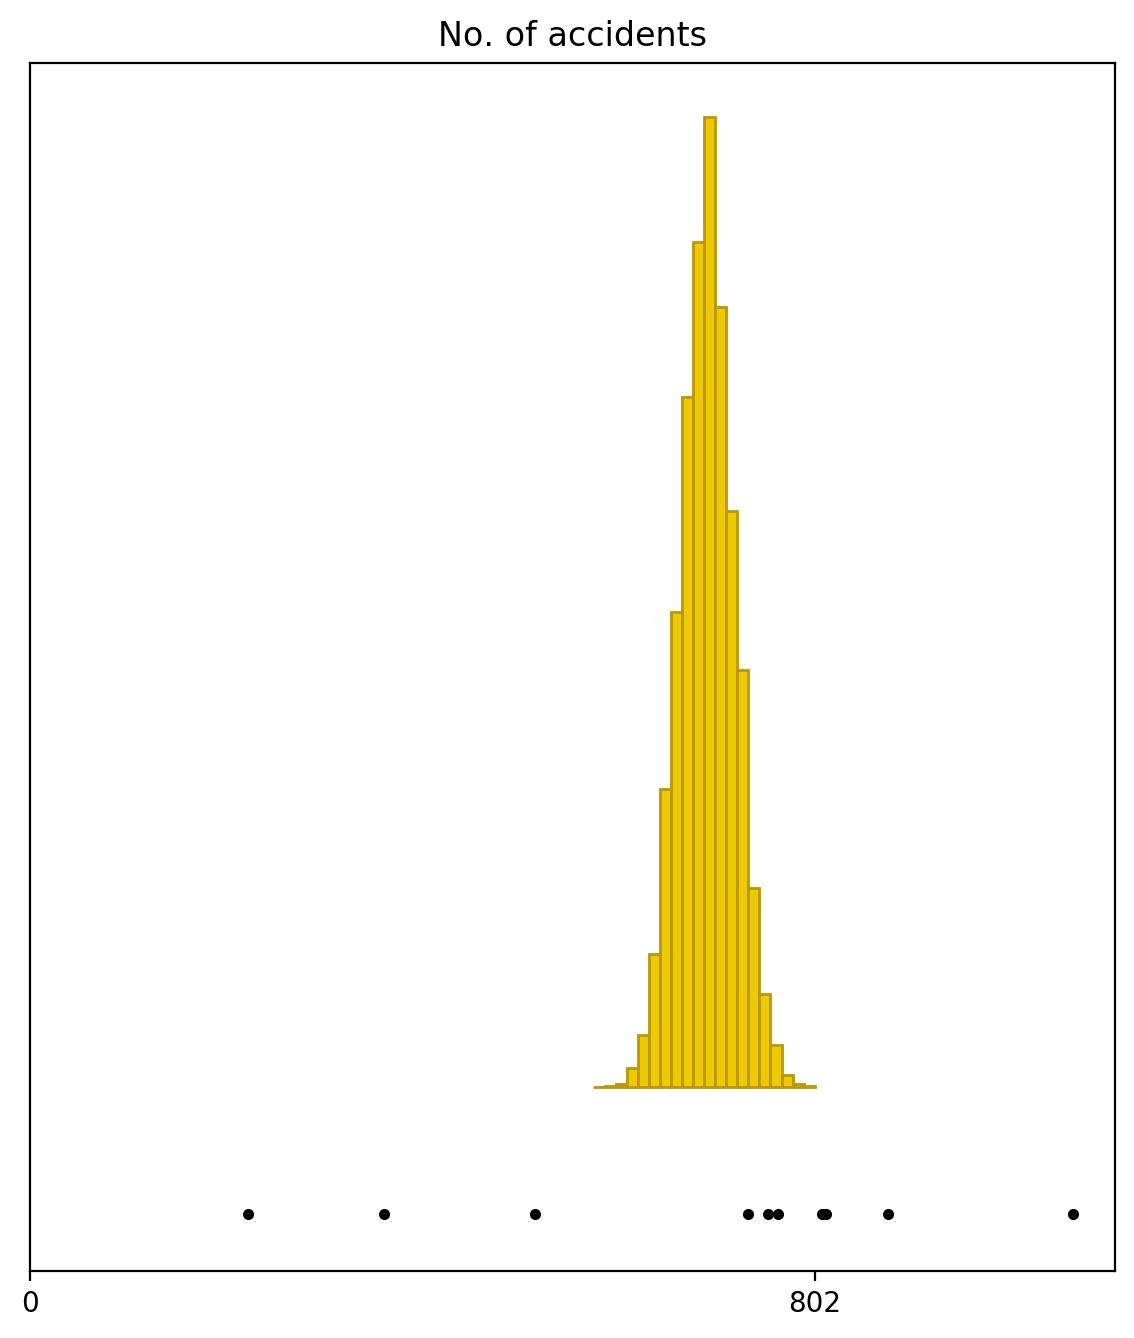

In [148]:
fig, ax = plt.subplots(1, 1,figsize=(7, 8))

ax.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax.scatter(accDeath,0.002*dta_cntDeath,color='black',marker='.',zorder=2)
ax.set_xticks([0,np.max(y_sim)])
ax.set_yticks([])
ax.set_title('No. of accidents')
plt.show()

### Using model for prediction

In 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown. Lets check how our can perform such prediction.


In [149]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted accidents = 692.0
Confidence interval = [ 648.0 735.0 ]


# Summary of lab 4.1
So if we would use first model to predict, data would be rubish.
It is really hard to predict data which oscillate from year to year so much and isn't connected with other parameters.


# Lab 4.2
2.The intensity is constant, but rate is a product of intensity and miles flown.

We decompose rate $\lambda$ into intensity $\theta$ and exposure $n$, i.e.

$$y_i\sim\mathrm{Poisson}(\theta n)$$
With $n$ being a number miles flown (in 100 mil)

In [150]:
mean_miles=np.mean(Airline_data["Miles flown [100 mln miles]"])
mean_pd=np.mean(Airline_data["Passenger deaths"])
mean_dr=np.mean(Airline_data["Death rate"])
mean_dr*=1000;
#I had to multiply it by 1000 because it was imposible to 
#generate appropriate pdf with values below 1
print(mean_miles)
print(mean_pd)
print(mean_dr)

5715.8
691.9
126.0


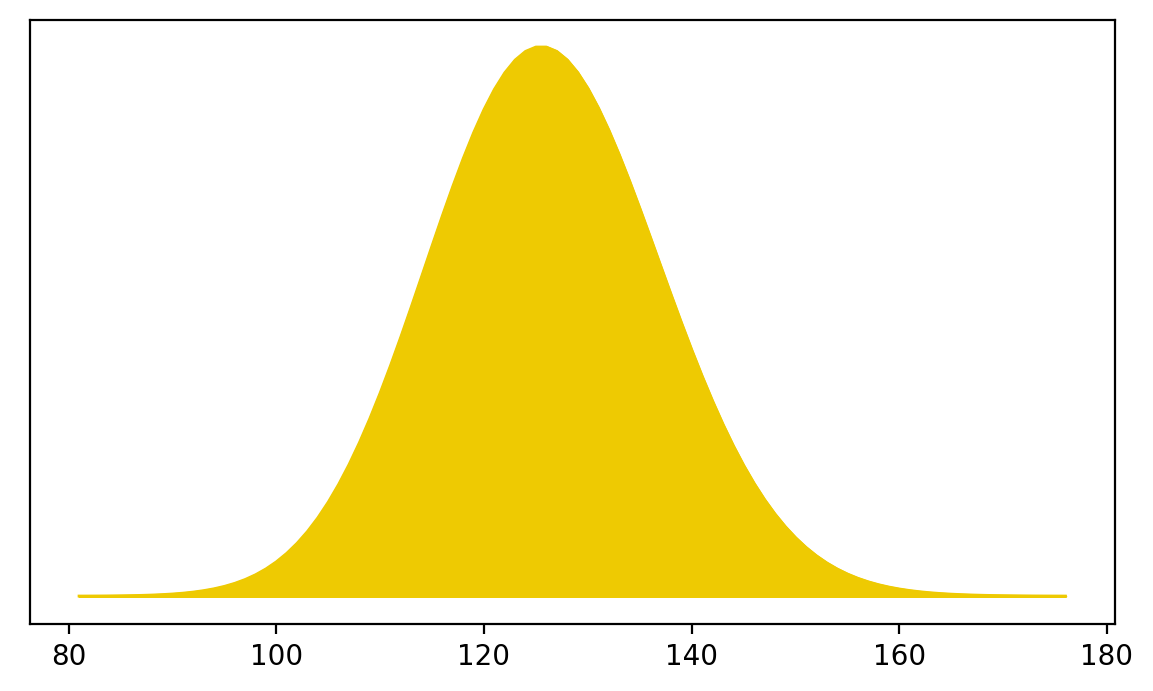

In [151]:
mu=mean_dr;
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x = np.arange(stats.poisson.ppf(0.00001, mu),stats.poisson.ppf(0.99999, mu))
ax2.plot(x,stats.poisson.pmf(x,mu),color=dark,linewidth=1)
ax2.fill_between(x,stats.poisson.pmf(x,mu),color=dark)
ax2.set_yticks([])
plt.show()

In [152]:
with open('poisson_prior.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  real lam;
}


generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lam);
  }
}



In [153]:
model_prior=pystan.StanModel('poisson_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_941ddc41fd8ed061ff465f3ef8b367ff NOW.


In [154]:
R=1000
data = dict(M = 1,
            lam = mean_dr)
sim_uf=model_prior.sampling(data=data,
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

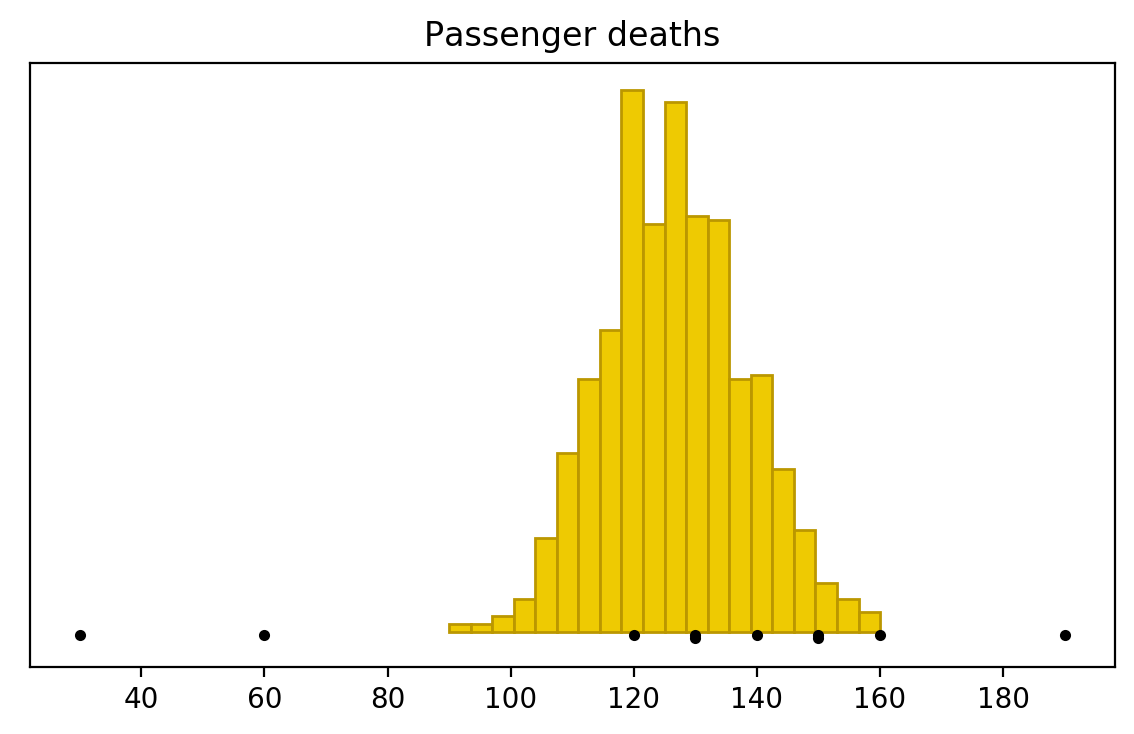

In [155]:
params=sim_uf.extract()
y_sim=params['y_sim']

fig, ax = plt.subplots(1, 1,figsize=(7, 4))
ax.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax.scatter(acc,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax.set_yticks([])

ax.set_title('Passenger deaths')
plt.show()

In [156]:
with open('poisson_prior_miles.stan', 'r') as file:
    print(file.read())


data {
  int M;//number of years analyzed
  real theta;
  vector[M] miles; //number of miles flown each year
  
}


generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}



In [157]:
model_prior=pystan.StanModel('poisson_prior_miles.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_087e19b3d29ba95f7f95c5c506d76269 NOW.


In [158]:
R=1000
data_prior=dict(M=len(Airline_data),theta=mean_dr/1000,miles=Airline_data['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=29042020)

In [159]:
params=sim_uf.extract()
y_sim=params['y_sim']


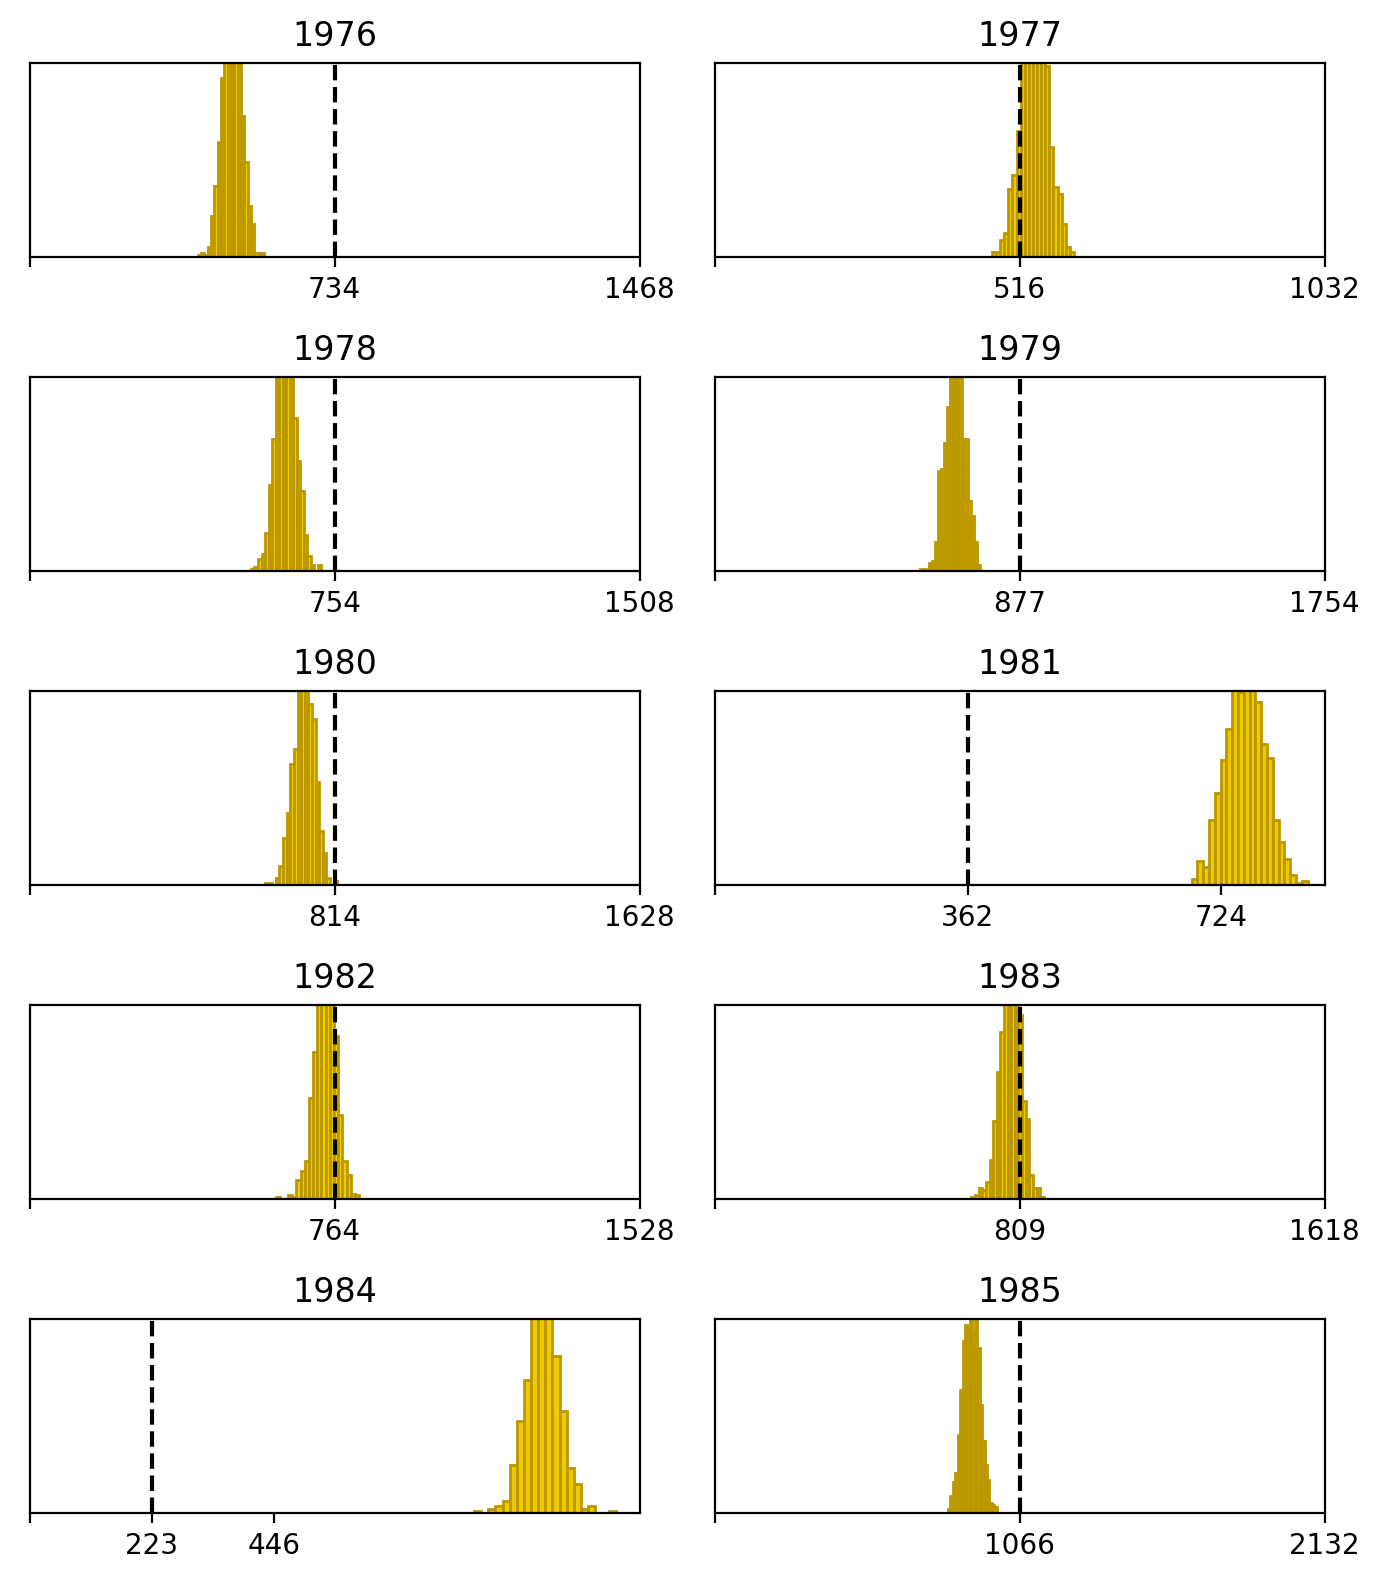

In [160]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,2*tv])
    ax.set_xticklabels(['',tv,2*tv])
    ax.set_ylim([0,0.012])

fig.tight_layout()

plt.show()

### Using model for prediction

In this situation prediction might be a slight more complicated, as it requires from us modifying the generated quantities block
As stated before in 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown. 

In [161]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [162]:
with open('poisson_miles_1986.stan', 'r') as file:
    print(file.read())


data {
  int M;//number of years analyzed
  real theta;
  vector[M] miles; //number of miles flown each year
  int y[M];//number of deaths
}

model {

  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}



In [163]:
model1986=pystan.StanModel('poisson_miles_1986.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4fba0a9cc20c0a54563e6b1149c1726b NOW.


In [164]:
data = dict(M = len(Airline_data),
            theta=mean_dr/1000,
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit1986 = model1986.sampling(data=data, algorithm="Fixed_param",seed=8052020)

y_1986=fit1986.extract()['y_1986']

In [165]:
median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.89)

print('Median of predicted accidents =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Median of predicted accidents = 1146.0
Confidence interval = [ 1090.0 1198.0 ]


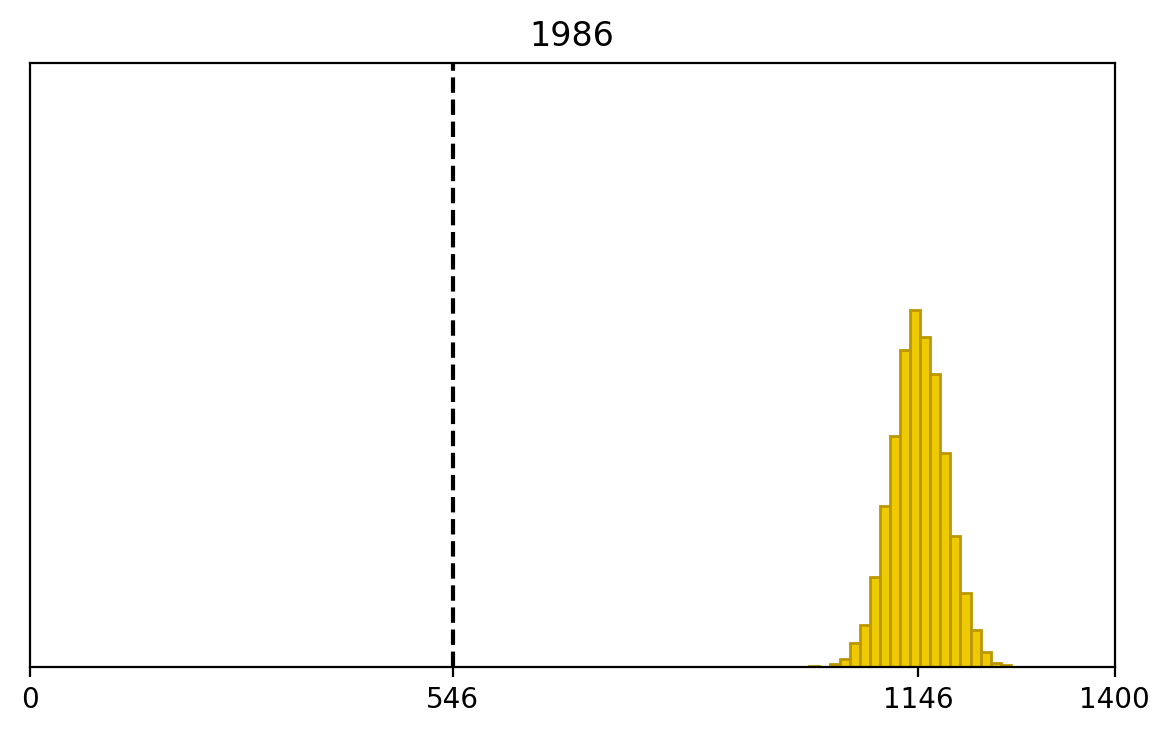

In [173]:
y_sim=params['y_sim']
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_1986,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('1986')
tv = 546
ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
ax.set_yticks([])
ax.set_xticks([0,tv,median_y_1986,1400])
#ax.set_xticklabels(['0',tv,50])
ax.set_ylim([0,0.02])


plt.show()

# Summary of lab 4.2
Trying to predictive number of passengers deaths wasn't successful.
These values really vary from year to year. They are not strictly connected with miles flown. 
Using miles flown gives much better results, but it isn't enaugh to  year to year so much and isn't connected with other parameters.